# Imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download Dataset

In [5]:
file={"username":"mojtabanafez","key":"7c0ebd541704e0cb4357c05f78ed5fa2"}
import json
with open('kaggle.json', 'w') as fp:
    json.dump(file, fp)
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

100% 1.82G/1.83G [00:28<00:00, 146MB/s]
100% 1.83G/1.83G [00:28<00:00, 69.5MB/s]


In [ ]:
# !gdown --id 1-8UrAsreTpYezl2z58xdg8v6ab2BbYmu

In [7]:
!unzip -q /content/stanford-car-dataset-by-classes-folder.zip

# Create Generator

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

TRAIN_DATA_PATH = "./car_data/car_data/train"
TEST_DATA_PATH = "./car_data/car_data/test"

TRANSFORM_IMG_TRAIN =  transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Resize(size=(224,224)), 
      transforms.RandomRotation(30),
      transforms.RandomHorizontalFlip(),
     ])

TRANSFORM_IMG_TEST =  transforms.Compose(
    [
      transforms.ToTensor(), 
      transforms.Resize(size=(224,224)),
     ])

BATCH_SIZE=32
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG_TRAIN)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG_TEST)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) 


In [9]:
len(train_data_loader), len(test_data_loader)

(255, 252)

In [10]:
dl=iter(train_data_loader)
x, y= next(dl)
x.shape, y.shape, torch.mean(x), torch.min(x), torch.max(x)

(torch.Size([32, 3, 224, 224]),
 torch.Size([32]),
 tensor(0.4195),
 tensor(0.),
 tensor(1.))

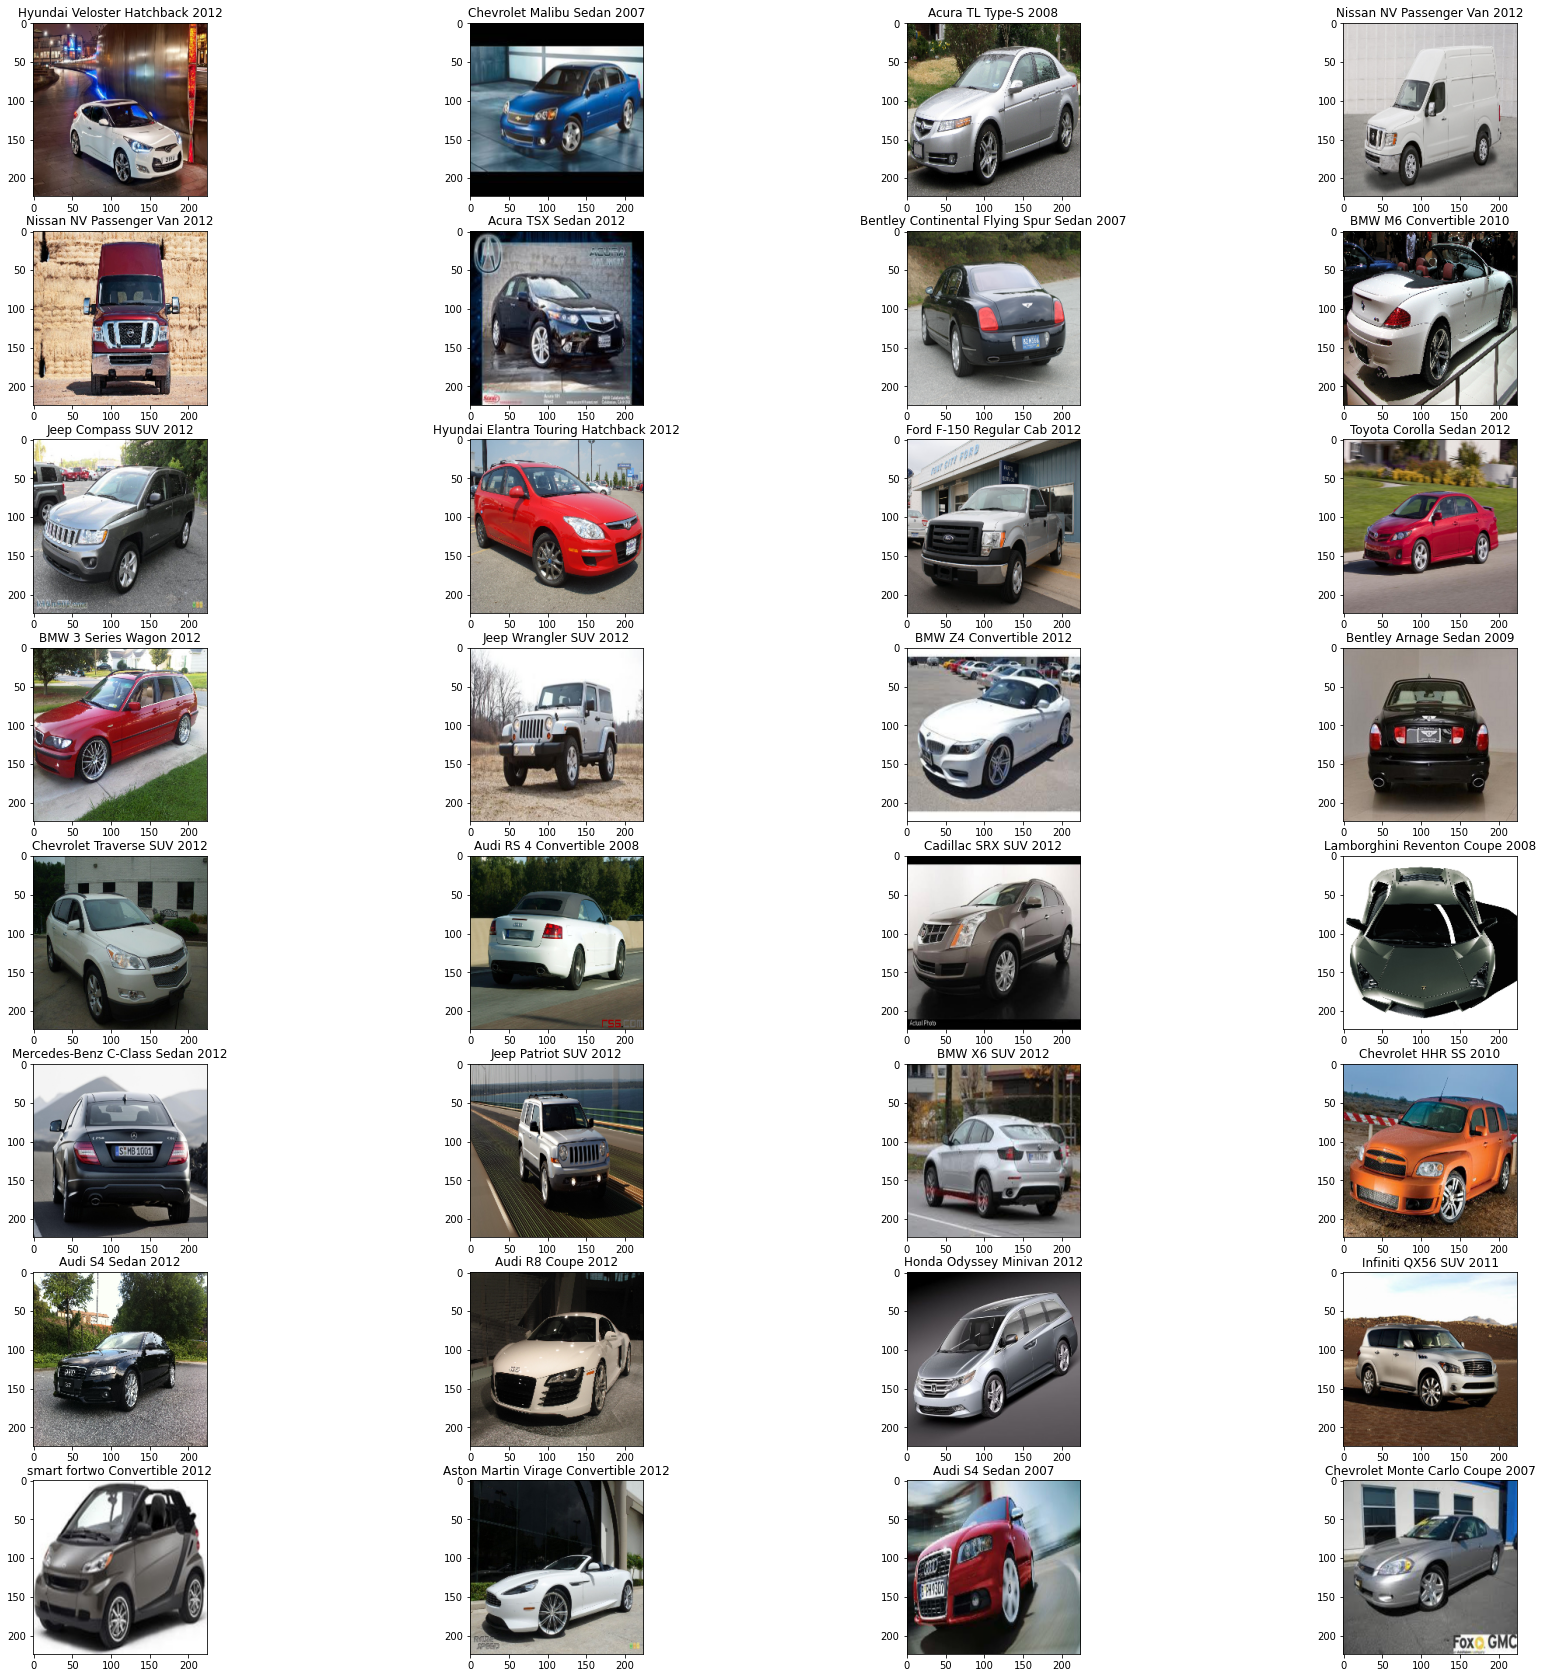

In [20]:
import numpy as np

classes = list(train_data.class_to_idx)


test_loader=iter(test_data_loader)
image, labels = test_loader.next()
image=np.array(image)
nrows=8
ncols=4
plt.figure (figsize = (30, 30))
image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 1, 2))
for i in range(image.shape[0]):
    sp = plt.subplot(nrows, ncols, i+1)
    plt.imshow(image[i])
    plt.title(classes[int(labels[i])])
plt.show()
# print(image.shape, np.mean(image), np.max(image), np.min(image))

In [23]:
dataloaders={
    'train':train_data_loader,
    'val': test_data_loader
}
dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'val']}

def save_checkpoint (state, filename):
    """ saving model's weights """
    print ('=> saving checkpoint')
    torch.save (state, filename)


def load_checkpoint (checkpoint, model):
    """ loading model's weights """
    print ('=> loading checkpoint')
    model.load_state_dict (checkpoint ['state_dict'])


def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = torch.squeeze(outputs)
                    loss = criterion(outputs.float(), labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                current_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                current_corrects += torch.sum(preds == labels.data)            


            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
                save_checkpoint(checkpoint, f'/content/drive/MyDrive/HW10_Weights/{model.name}.pth')

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model
dataset_sizes

{'train': 255, 'val': 252}

In [12]:
class ResnetModel(nn.Module):
    def __init__(self, name, original_model, num_classes, classifier=None):
        super(ResnetModel, self).__init__()

        self.name = name

        # Everything except the last linear layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        if classifier:
            self.classifier = classifier
        else:
            self.classifier = nn.Sequential(
                nn.Linear(2048, num_classes),
            )

    def forward(self, x):
        f = self.features(x)
        f = f.view(f.size(0), -1)
        y = self.classifier(f)
        return y


# **A**

In [ ]:
# Build Model
res_mod = models.resnet50(pretrained=False)
model = ResnetModel('rand_weighted_model', res_mod, num_classes=len(classes))

checkpoint = torch.load(f'/content/drive/MyDrive/HW10_Weights/{model.name}.pth')
load_checkpoint(checkpoint, model)


# Train Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

optimizer_ft.load_state_dict(checkpoint['optimizer'])

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
base_model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

=> loading checkpoint
Epoch 0/9
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 157.4702 Acc: 0.8392
Iterating through data...
val Loss: 159.8266 Acc: 0.7381
=> saving checkpoint

Epoch 1/9
----------
Iterating through data...
train Loss: 156.3277 Acc: 0.9490
Iterating through data...
val Loss: 159.0449 Acc: 0.7381

Epoch 2/9
----------
Iterating through data...
train Loss: 155.1623 Acc: 0.9961
Iterating through data...
val Loss: 158.1986 Acc: 0.8810
=> saving checkpoint

Epoch 3/9
----------
Iterating through data...
train Loss: 153.6648 Acc: 1.0706
Iterating through data...
val Loss: 156.4941 Acc: 0.9008
=> saving checkpoint

Epoch 4/9
----------
Iterating through data...
train Loss: 151.7034 Acc: 1.2588
Iterating through data...
val Loss: 156.5763 Acc: 0.9881
=> saving checkpoint

Epoch 5/9
----------
Iterating through data...
train Loss: 148.9455 Acc: 1.4902
Iterating through data...
val Loss: 153.1402 Acc: 1.1349
=> saving checkpoint

Epoch 6/9
----------
Iterating through data...
train Loss: 145.0282 Acc: 1.8157
Iterating through data...
val Loss

# **B**

In [18]:
def build_classifier_model(input_num, classes_num):
    classifier = nn.Sequential()
    classifier.add_module('fc0', nn.Linear(in_features=input_num, out_features= 1024))
    classifier.add_module('relu0', nn.ReLU())
    classifier.add_module('output', nn.Linear(in_features=1024, out_features=classes_num))
    return classifier

In [ ]:
# Build Model
base_model = models.resnet50(pretrained=True)

for param in base_model.parameters():
    param.requires_grad = False

classifier_model = build_classifier_model(base_model.fc.in_features, 196)

model = ResnetModel('simple_classifier', base_model, num_classes=len(classes), classifier=classifier_model)

checkpoint = torch.load(f'/content/drive/MyDrive/HW10_Weights/{model.name}.pth')
load_checkpoint(checkpoint, model)

# Train model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss()

# segment learnable params
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

# definition of optimizer
optimizer_ft = optim.Adam(params_to_update, lr=0.001)

optimizer_ft.load_state_dict(checkpoint['optimizer'])

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
trained_model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

=> loading checkpoint
Epoch 0/14
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 147.6088 Acc: 0.7843
Iterating through data...
val Loss: 142.9686 Acc: 1.1032
=> saving checkpoint

Epoch 1/14
----------
Iterating through data...
train Loss: 146.7805 Acc: 0.8118
Iterating through data...
val Loss: 142.1399 Acc: 0.9444

Epoch 2/14
----------
Iterating through data...
train Loss: 145.6782 Acc: 1.0039
Iterating through data...
val Loss: 140.9116 Acc: 1.2976
=> saving checkpoint

Epoch 3/14
----------
Iterating through data...
train Loss: 145.6658 Acc: 0.9059
Iterating through data...
val Loss: 140.1101 Acc: 1.0754

Epoch 4/14
----------
Iterating through data...
train Loss: 144.8887 Acc: 1.0078
Iterating through data...
val Loss: 140.6097 Acc: 1.1349

Epoch 5/14
----------
Iterating through data...
train Loss: 144.1945 Acc: 1.0196
Iterating through data...
val Loss: 139.1927 Acc: 1.2937

Epoch 6/14
----------
Iterating through data...
train Loss: 142.6401 Acc: 1.2745
Iterating through data...
val Loss: 138.5441 Acc: 1.3690
=> saving checkpoint

Epoch 7/14
-

# **C**

In [13]:
def train_model_qc(model, classifier_model, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    first_step = True

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                classifier_input = outputs.to('cpu').detach().numpy()
                classifier_target = labels.to('cpu').detach().numpy()
                
                if not first_step:
                    preds = classifier_model.predict(classifier_input)
                    current_corrects += np.sum(preds == classifier_target)
                first_step = False
                
                if phase == 'train':
                    classifier_model.fit(classifier_input, classifier_target)           

            epoch_acc = current_corrects / dataset_sizes[phase]
            print('{} Acc: {:.4f}'.format(phase, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                dump(classifier_model, '/content/drive/MyDrive/HW10_Weights/svm_classifier.joblib') 

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    return model

In [16]:
# Build model
from sklearn.svm import SVC
from joblib import dump, load

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
model = model.to(device)

classifier_model = SVC(kernel='poly', C=1)

classifier_model = load('/content/drive/MyDrive/HW10_Weights/svm_classifier.joblib')

train_model_qc(model, classifier_model, 17)

Epoch 0/16
----------
Iterating through data...
train Acc: 0.1333
Iterating through data...
val Acc: 0.2222

Epoch 1/16
----------
Iterating through data...
train Acc: 0.1765
Iterating through data...
val Acc: 0.1667

Epoch 2/16
----------
Iterating through data...
train Acc: 0.1922
Iterating through data...
val Acc: 0.2024

Epoch 3/16
----------
Iterating through data...
train Acc: 0.2039
Iterating through data...
val Acc: 0.2381

Epoch 4/16
----------
Iterating through data...
train Acc: 0.1843
Iterating through data...
val Acc: 0.1627

Epoch 5/16
----------
Iterating through data...
train Acc: 0.2078
Iterating through data...
val Acc: 0.2659

Epoch 6/16
----------
Iterating through data...
train Acc: 0.1647
Iterating through data...
val Acc: 0.1508

Epoch 7/16
----------
Iterating through data...
train Acc: 0.1882
Iterating through data...
val Acc: 0.2103

Epoch 8/16
----------
Iterating through data...
train Acc: 0.1608
Iterating through data...
val Acc: 0.2143

Epoch 9/16
--------

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# **D**

In [24]:
# Build Model
base_model = models.resnet50(pretrained=True)

for param in base_model.parameters():
    param.requires_grad = True

classifier_model = build_classifier_model(base_model.fc.in_features, 196)

model = ResnetModel('simple_classifier_after_fine_tune', base_model, num_classes=len(classes), classifier=classifier_model)

model_b_checkpoint = torch.load('/content/drive/MyDrive/HW10_Weights/simple_classifier.pth')
load_checkpoint(model_b_checkpoint, model)

# checkpoint = torch.load(f'/content/drive/MyDrive/HW10_Weights/{model.name}.pth')
# load_checkpoint(checkpoint, model)

# Train model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss()

# segment learnable params
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

# definition of optimizer
optimizer_ft = optim.Adam(params_to_update, lr=0.001)

# optimizer_ft.load_state_dict(checkpoint['optimizer'])

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
trained_model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

=> loading checkpoint
Epoch 0/4
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 158.8783 Acc: 0.5176
Iterating through data...
val Loss: 159.7700 Acc: 0.5556
=> saving checkpoint

Epoch 1/4
----------
Iterating through data...
train Loss: 147.0982 Acc: 0.8039
Iterating through data...
val Loss: 154.6950 Acc: 0.7222
=> saving checkpoint

Epoch 2/4
----------
Iterating through data...
train Loss: 140.7707 Acc: 1.0549
Iterating through data...
val Loss: 141.8927 Acc: 1.1548
=> saving checkpoint

Epoch 3/4
----------
Iterating through data...
train Loss: 137.2878 Acc: 1.1373
Iterating through data...
val Loss: 138.6286 Acc: 1.3056
=> saving checkpoint

Epoch 4/4
----------
Iterating through data...
train Loss: 133.2228 Acc: 1.3882
Iterating through data...
val Loss: 131.0654 Acc: 1.5992
=> saving checkpoint

Training complete in 26m 2s
Best val Acc: 1.599206


# **E**

In [90]:
base_model = models.resnet50(pretrained=True)

for param in base_model.parameters():
    param.requires_grad = False

classifier_model = build_classifier_model(base_model.fc.in_features, 196)

model_nft = ResnetModel('simple_classifier', base_model, num_classes=len(classes), classifier=classifier_model)
model_nft = model_nft.to(device)

checkpoint = torch.load(f'/content/drive/MyDrive/HW10_Weights/{model_nft.name}.pth')
load_checkpoint(checkpoint, model_nft)

=> loading checkpoint


In [92]:
base_model = models.resnet50(pretrained=True)

for param in base_model.parameters():
    param.requires_grad = False

classifier_model = build_classifier_model(base_model.fc.in_features, 196)

model_ft = ResnetModel('simple_classifier_after_fine_tune', base_model, num_classes=len(classes), classifier=classifier_model)
model_ft = model_ft.to(device)

checkpoint = torch.load(f'/content/drive/MyDrive/HW10_Weights/{model_ft.name}.pth')
load_checkpoint(checkpoint, model_ft)

=> loading checkpoint


In [93]:
# Sample data

data_itr = iter(train_data_loader)
X, Y = next(data_itr)
X = X.to(device)

sample = X[0]
shape = (1, 3, 224, 224)
sample = sample.reshape(shape)

sample = sample.to(device)


In [94]:
class SaveOutput:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []

In [95]:
def plot(model):
    save_output = SaveOutput()
    hook_handles = []

    for layer in model_ft.modules():
        handle = layer.register_forward_hook(save_output)
        hook_handles.append(handle)

    out = model(sample)

    zero_percents = []
    for ly in save_output.outputs:
        flatten = torch.flatten(ly)
        percent = float(sum(flatten == 0.0)) / float(len(flatten))
        zero_percents.append(percent)

    plt.plot(zero_percents)
    plt.xlabel('layers')
    plt.show()

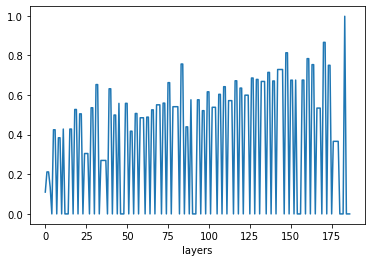

In [96]:
plot(model_ft)

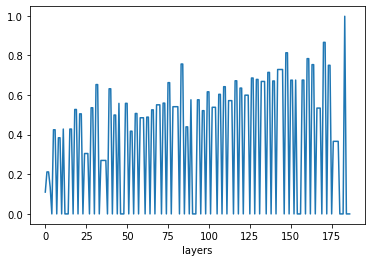

In [97]:
plot(model_nft)